In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv("data.csv", index_col="Date")

In [147]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()[["Close"]] 
    
    # Adjust the input columns to get the current day's close as the last input feature
    for i in range(1, input_length):
        df[f'x_{i}'] = df['Close'].shift(i)

    # Get the next 14 days for response values
    for j in range(output_length):
        df[f'y_{j}'] = df['Close'].shift(-j-1)
    
    df = df.dropna(axis=0)
    return df
window = 60
window_df = window_input_output(window, 14, data) # multiple columns for response variables
full_window_df = data.merge(window_df.drop(columns=["Close"]), left_on='Date', right_on='Date', how='inner')

train/test split

In [151]:
from sklearn.model_selection import TimeSeriesSplit
df = full_window_df.copy()
train_size = int(len(df) * 0.9)
test_size = int(len(df) * 0.1)
# Split the DataFrame into df_train and df_test
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:train_size+test_size]
# Separate features and target variables
X = df_train.drop(columns=[f'y_{i}' for i in range(14)])
y = df_train[[f'y_{i}' for i in range(14)]]
tscv = TimeSeriesSplit(n_splits=5, test_size=len(df_train)//10) 
#model needs to predict up to two weeks into future
#we use expanding windows, enuring within each fold the train data isnt exposed to test data
# Separate features and target variables
X_test = df_test.drop(columns=[f'y_{i}' for i in range(14)])
y_test = df_test[[f'y_{i}' for i in range(14)]]




regression

In [150]:
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
lm_seq = LinearRegression()
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
dt_seq = DecisionTreeRegressor(random_state=42)
from sklearn.ensemble import RandomForestRegressor
rf_seq = RandomForestRegressor(n_estimators=300, random_state=42)
##Chained Regression
from sklearn.multioutput import RegressorChain

lm_chain = RegressorChain(LinearRegression())


for train_index, test_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    #lm_seq.fit(X_train, y_train)
    #lm_seq_pred = lm_seq.predict(X_val)
    # Create a dictionary of parameter values to search over
    param_grid = {'n_features_to_select': [5, 10, 15, 20, 25, 30, 40, 50]}

    # Create an instance of RFE
    lm_rfe = RFE(estimator=lm_seq)
    lm_grid_search = GridSearchCV(estimator=lm_rfe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
    lm_grid_search.fit(X_train, y_train)
    lm_best_n_features = lm_grid_search.best_params_['n_features_to_select']
    print("Best n_features_to_select for lm:", lm_best_n_features)

    rfe_lm_seq = RFE(estimator=lm_seq, n_features_to_select=lm_best_n_features)
    X_train_rfe_lm_seq = rfe_lm_seq.fit_transform(X_train, y_train)
    X_val_rfe_lm_seq = rfe_lm_seq.transform(X_val)  
    lm_seq.fit(X_train_rfe_lm_seq, y_train)
    lm_seq_pred = lm_seq.predict(X_val_rfe_lm_seq)

    dt_seq.fit(X_train, y_train)
    dt_seq_pred = dt_seq.predict(X_val) 
    rf_seq.fit(X_train, y_train)
    rf_seq_pred = rf_seq.predict(X_val)   
    lm_chain.fit(X_train, y_train)
    lm_chain_pred = lm_chain.predict(X_val)
    
    # Calculate MSE for each output column
    mse_rf = [mean_squared_error(y_val.iloc[:, i], rf_seq_pred[:, i]) for i in range(y_val.shape[1])]
    mse_dt = [mean_squared_error(y_val.iloc[:, i], dt_seq_pred[:, i]) for i in range(y_val.shape[1])]
    mse_lm = [mean_squared_error(y_val.iloc[:, i], lm_seq_pred[:, i]) for i in range(y_val.shape[1])]
    mse_lm_chain = [mean_squared_error(y_val.iloc[:, i], lm_chain_pred[:, i]) for i in range(y_val.shape[1])]
    #  to do: get best of each model from the splits
mse_df = pd.DataFrame({
    'rf': mse_rf,
    'dt': mse_dt,
    'lm': mse_lm,
    'chain_lm': mse_lm_chain
})
print(mse_df)

Best n_features_to_select for lm: 5
Best n_features_to_select for lm: 5
Best n_features_to_select for lm: 5
Best n_features_to_select for lm: 5
Best n_features_to_select for lm: 5
              rf            dt           lm     chain_lm
0    4686.789169   4874.289333   166.503267   173.701805
1    5257.282664   6503.798587   346.903405   361.599315
2    5809.268433   7912.462322   564.814223   548.659809
3    6312.059365   7402.070756   743.021361   694.411249
4    6930.138467   8701.743947   930.980947   828.200696
5    7751.526116   9421.620421  1167.129420   999.274991
6    8645.887279   9208.214700  1448.090898  1177.952027
7    9784.378904  10452.714713  1669.279140  1324.192153
8   11032.181427  13127.997932  1921.886650  1441.148388
9   12207.437536  14531.162116  2274.710180  1645.196093
10  13347.964894  16463.644630  2551.931793  1768.622854
11  14649.879464  18280.249583  2871.299644  1942.541693
12  15628.871082  20598.299087  3365.929412  2202.406675
13  16746.827769  2052

test models

In [152]:
lm_seq_pred = lm_seq.predict(rfe_lm_seq.transform(X_test))
dt_seq_pred = dt_seq.predict(X_test) 
rf_seq_pred = rf_seq.predict(X_test)   
lm_chain_pred = lm_chain.predict(X_test)

# Calculate MSE for each output column
mse_rf = [mean_squared_error(y_test.iloc[:, i], rf_seq_pred[:, i]) for i in range(y_test.shape[1])]
mse_dt = [mean_squared_error(y_test.iloc[:, i], dt_seq_pred[:, i]) for i in range(y_test.shape[1])]
mse_lm = [mean_squared_error(y_test.iloc[:, i], lm_seq_pred[:, i]) for i in range(y_test.shape[1])]
mse_lm_chain = [mean_squared_error(y_test.iloc[:, i], lm_chain_pred[:, i]) for i in range(y_test.shape[1])]
test_mse_df = pd.DataFrame({
    'rf': mse_rf,
    'dt': mse_dt,
    'lm': mse_lm,
    'chain_lm': mse_lm_chain
})
print(test_mse_df)

              rf            dt           lm     chain_lm
0   27706.669719  21937.338603   125.997718   135.433424
1   28740.594631  24393.622938   249.960291   268.371107
2   29955.946226  29933.791290   363.076571   402.020876
3   30734.263970  28011.998716   483.775380   578.850923
4   31768.374144  31224.985706   595.796599   727.953391
5   33271.194799  30766.311825   737.483629   883.373795
6   34481.932409  29369.376425   879.861926   943.190441
7   36010.027862  28806.044186  1032.718986  1054.046128
8   37453.174177  33940.504892  1205.535139  1248.753668
9   39040.764932  32682.676697  1400.612228  1341.804357
10  40611.375024  36609.300077  1608.782129  1501.091038
11  42458.563238  40008.891898  1826.273641  1645.059936
12  43846.739717  43958.905817  2211.214576  1695.333912
13  45064.378637  47352.484496  2465.953433  1749.009425


Save Data

In [ ]:
#window_df.to_csv("window_df.csv")

visualisation

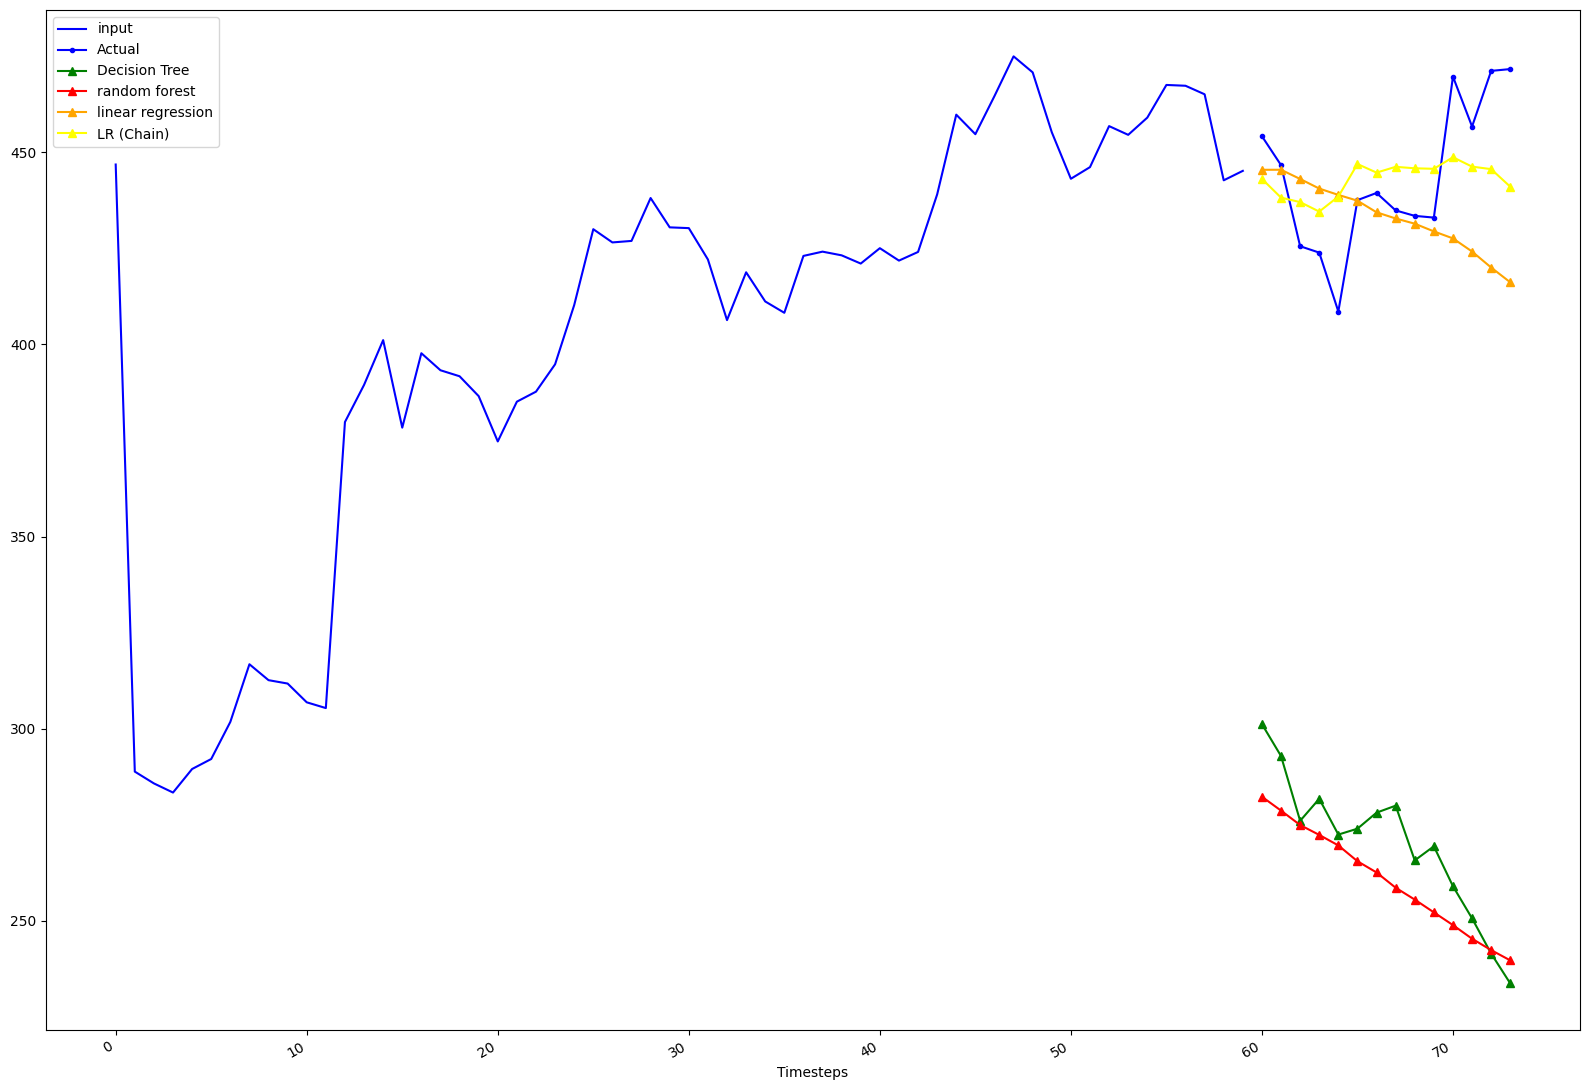

In [158]:

#visualise predictions
fig, ax = plt.subplots(figsize=(16, 11))
t= 30
columns = [f'x_{i}' for i in range(1, 60)] + ["Close"]
ax.plot(np.arange(window-1, -1, -1), X_test[columns].iloc[t], 'b-', label='input')
ax.plot(np.arange(window, window+14, 1), y_test.iloc[t], marker='.', color='blue', label='Actual')
ax.plot(np.arange(window, window+14, 1), dt_seq_pred[t], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(window, window+14, 1), rf_seq_pred[t], marker='^', color='red', label='random forest')
ax.plot(np.arange(window, window+14, 1), lm_seq_pred[t], marker='^', color='orange', label='linear regression')
ax.plot(np.arange(window, window+14, 1), lm_chain_pred[t], marker='^', color='yellow', label='LR (Chain)')

ax.set_xlabel('Timesteps')
plt.legend()

fig.autofmt_xdate()
plt.tight_layout()
